<a href="https://colab.research.google.com/github/sameekshya1999/customerchurn/blob/main/churn_with_local_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

📂 Please upload train.csv and test.csv


Saving test.csv to test (1).csv
Saving train.csv to train (1).csv
🔧 Cleaning + encoding data...
📊 Running 5-Fold Stratified CV...
Fold 1 - Validation Accuracy: 0.9960
Fold 2 - Validation Accuracy: 0.9957
Fold 3 - Validation Accuracy: 0.9954
Fold 4 - Validation Accuracy: 0.9958
Fold 5 - Validation Accuracy: 0.9958

Average CV Accuracy: 0.9957
🧠 Training final model with class weights...
Class weights: {0: 1.0, 1: 0.7633338166690834}
Epoch 1/15
11021/11021 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - accuracy: 0.9685 - loss: 0.0741 - val_accuracy: 0.9918 - val_loss: 0.0212
Epoch 2/15
11021/11021 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - accuracy: 0.9849 - loss: 0.0355 - val_accuracy: 0.9935 - val_loss: 0.0168
Epoch 3/15
11021/11021 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - accuracy: 0.9874 - loss: 0.0295 - val_accuracy: 0.9935 - val_loss: 0.0161
Epoch 4/15
11021/11021 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - accuracy: 0.9881 - loss: 0.0274 - val_accuracy: 0.9937 - val_loss: 0.0157
Epoch 5/15
11021/11021 ━━━━━━━━━

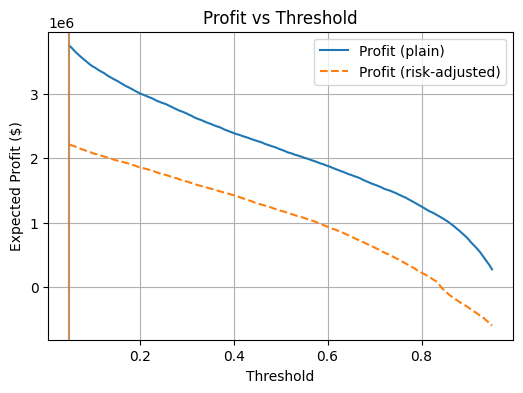


Top 15 high-risk customers (risk-adjusted):


,pred_prob_mean,pred_uncertainty,risk_adjusted_score,true_label
0,1.0,0.000000e+00,1.0,0
1,1.0,0.000000e+00,1.0,0
2,1.0,0.000000e+00,1.0,0
3,1.0,0.000000e+00,1.0,1
4,1.0,0.000000e+00,1.0,1
5,1.0,0.000000e+00,1.0,0
6,1.0,2.384186e-08,1.0,0
7,1.0,8.429369e-09,1.0,1
8,1.0,8.429369e-09,1.0,0
9,1.0,1.685874e-08,1.0,1


In [2]:
# ============================================================
# 🔮 Customer Churn Prediction with CV, Early Stopping, Uncertainty
# ============================================================

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from google.colab import files

# -----------------------------
# 1) Upload Files
# -----------------------------
print("📂 Please upload train.csv and test.csv")
uploaded = files.upload()

train_path = "train.csv"
test_path  = "test.csv"
df_train = pd.read_csv(train_path)
df_test  = pd.read_csv(test_path)

# -----------------------------
# 2) Cleaning & Encoding
# -----------------------------
print("🔧 Cleaning + encoding data...")

# Drop rows where Churn is NaN
df_train = df_train.dropna(subset=["Churn"])
df_test  = df_test.dropna(subset=["Churn"])

# Encode categoricals with safe handling for unseen test values
label_encoders = {}
for col in df_train.columns:
    if df_train[col].dtype == "object":
        le = LabelEncoder()
        df_train[col] = le.fit_transform(df_train[col].astype(str))
        # Handle unseen categories in test
        unseen = set(df_test[col].astype(str)) - set(le.classes_)
        if unseen:
            le_classes = np.append(le.classes_, list(unseen))
            le.classes_ = le_classes
        df_test[col] = le.transform(df_test[col].astype(str))
        label_encoders[col] = le

# Split features & target
y = df_train["Churn"].astype(int).values
y_test = df_test["Churn"].astype(int).values
X = df_train.drop("Churn", axis=1)
X_test = df_test.drop("Churn", axis=1)

# Scale numeric features
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)

# -----------------------------
# 3) Model Builder
# -----------------------------
def build_model(dropout=0.3):
    m = keras.Sequential([
        layers.Input(shape=(X.shape[1],)),
        layers.Dense(128), layers.BatchNormalization(), layers.ReLU(),
        layers.Dropout(dropout),
        layers.Dense(64), layers.BatchNormalization(), layers.ReLU(),
        layers.Dropout(dropout),
        layers.Dense(1, activation="sigmoid")
    ])
    m.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return m

# -----------------------------
# 4) Cross-validation
# -----------------------------
print("📊 Running 5-Fold Stratified CV...")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_acc = []
for f,(tr,va) in enumerate(skf.split(X,y),1):
    m = build_model()
    es = keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
    m.fit(X[tr],y[tr], validation_data=(X[va],y[va]), epochs=15, batch_size=32, verbose=0, callbacks=[es])
    acc = m.evaluate(X[va],y[va], verbose=0)[1]
    print(f"Fold {f} - Validation Accuracy: {acc:.4f}")
    cv_acc.append(acc)
print(f"\nAverage CV Accuracy: {np.mean(cv_acc):.4f}")

# -----------------------------
# 5) Final Train + Class Weights
# -----------------------------
print("🧠 Training final model with class weights...")
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)
cnt = Counter(y_train); cw = {0:1.0, 1: cnt[0]/cnt[1]}
print("Class weights:", cw)

model = build_model()
es = keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=15,
                    batch_size=32, class_weight=cw, callbacks=[es], verbose=1)

# -----------------------------
# 6) Monte Carlo Dropout Uncertainty
# -----------------------------
print("🔄 Estimating uncertainty with Monte Carlo dropout...")
mc_model = build_model()
mc_model.set_weights(model.get_weights())

def mc_predict(mod, x, n_iter=50):
    preds = [mod(x, training=True).numpy().ravel() for _ in range(n_iter)]
    preds = np.vstack(preds)
    return preds.mean(axis=0), preds.std(axis=0)

p_mean, p_std = mc_predict(mc_model, X_test)

# -----------------------------
# 7) Profit Optimization
# -----------------------------
cost_fn = 200.0  # cost of losing a churner
cost_fp = 10.0   # cost of contacting a non-churner

def profit_at_threshold(t):
    y_hat = (p_mean >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_hat).ravel()
    profit = tp*(cost_fn - cost_fp) - fp*cost_fp - fn*cost_fn
    return profit, (tn, fp, fn, tp)

k_risk = 1.0
p_risk_adj = p_mean - k_risk*p_std
def profit_at_threshold_risk(t):
    y_hat = (p_risk_adj >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_hat).ravel()
    profit = tp*(cost_fn - cost_fp) - fp*cost_fp - fn*cost_fn
    return profit, (tn, fp, fn, tp)

ths = np.linspace(0.05, 0.95, 181)
profits = np.array([profit_at_threshold(t)[0] for t in ths])
profits_risk = np.array([profit_at_threshold_risk(t)[0] for t in ths])

t_best = ths[np.argmax(profits)]
t_best_risk = ths[np.argmax(profits_risk)]

print(f"\nBest profit threshold (plain): {t_best:.2f} | profit=${profits.max():.0f}")
print(f"Best profit threshold (risk-adjusted): {t_best_risk:.2f} | profit=${profits_risk.max():.0f}")

# -----------------------------
# 8) Final Reports
# -----------------------------
y_hat = (p_mean >= t_best).astype(int)
y_hat_risk = (p_risk_adj >= t_best_risk).astype(int)

print("\nClassification (profit-optimal, plain):")
print(classification_report(y_test, y_hat))
print("Confusion matrix (tn, fp, fn, tp):", confusion_matrix(y_test, y_hat).ravel())

print("\nClassification (profit-optimal, risk-adjusted):")
print(classification_report(y_test, y_hat_risk))
print("Confusion matrix (tn, fp, fn, tp):", confusion_matrix(y_test, y_hat_risk).ravel())

# -----------------------------
# 9) Visualization
# -----------------------------
plt.figure(figsize=(6,4))
plt.plot(ths, profits, label="Profit (plain)")
plt.plot(ths, profits_risk, label="Profit (risk-adjusted)", linestyle="--")
plt.axvline(t_best, color='C0', alpha=.6)
plt.axvline(t_best_risk, color='C1', alpha=.6)
plt.xlabel("Threshold"); plt.ylabel("Expected Profit ($)")
plt.title("Profit vs Threshold")
plt.legend(); plt.grid(); plt.show()

# -----------------------------
# 10) Top-Risk Customers
# -----------------------------
risk_score = p_risk_adj
rank_idx = np.argsort(-risk_score)
top = pd.DataFrame({
    "pred_prob_mean": p_mean[rank_idx],
    "pred_uncertainty": p_std[rank_idx],
    "risk_adjusted_score": risk_score[rank_idx],
    "true_label": y_test[rank_idx]
}).head(15)
print("\nTop 15 high-risk customers (risk-adjusted):")
display(top)
